In [2]:
!git clone https://gitlab.developers.cam.ac.uk/ch/thom/part2programming.git

Cloning into 'part2programming'...
remote: Enumerating objects: 4555, done.
remote: Total 4555 (delta 0), reused 0 (delta 0), pack-reused 4555 (from 1)
Receiving objects: 100% (4555/4555), 5.05 MiB | 3.35 MiB/s, done.
Resolving deltas: 100% (4527/4527), done.
Updating files: 100% (4550/4550), done.


Enter the directory of Gaussian output files: part2programming/Ex2/H2Ooutfiles


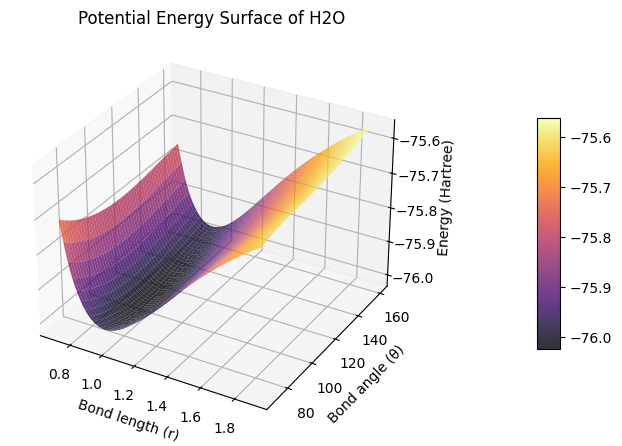


Fitting to 55 data points around equilibrium.

Fitted quadratic parameters:
r0 = 0.9511361249497605
theta0 (deg) = 105.41330341105449
k_r = 4.420037012513209
k_theta = 5.448093875203748e-05

Approximate symmetric stretch frequency: 4152.7 cm^-1
Approximate bending frequency: 1756.5 cm^-1


In [34]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

## Function to parse a Gaussian output file to extract r (X-H), theta (H-X-H), and E
## E calculated using HF theory

def extract_data(filename):

    ## Find relevant files with this name structure: rx.xxthetaxx.0.out

    match = re.search(r'r([0-9.]+)theta([0-9.]+)\.out', filename)
    if match:
        r = float(match.group(1))
        theta = float(match.group(2))
    else:
        raise ValueError(f"Could not extract geometry from filename {filename}")

    ## Read energy from the file
    ## Gaussian prints energies like SCF Done:  E(RHF) =  xxxxxx (5th element, float)

    energy = None
    with open(filename, 'r') as f:
        for line in f:
            if 'SCF Done:' in line:
              energy = float(line.split()[4])
    if energy is None:
        raise ValueError(f"Energy not found in {filename}")

    return r, theta, energy

## Loop over .out files from a directory and utilise extract_data function
## Collects relevant data in arrays

def read_directory(directory):

    files = [f for f in os.listdir(directory) if f.endswith('.out')]

    ## Initialise arrays then append with relevant data

    r_list, theta_list, E_list = [], [], []

    for file in files:
        r, theta, E = extract_data(os.path.join(directory, file))
        r_list.append(r)
        theta_list.append(theta)
        E_list.append(E)

    return np.array(r_list), np.array(theta_list), np.array(E_list)

## Function to return r, theta and energy at energy minimum
## Finds index of lowest energy using Numpy's argmin

def find_equilibrium(r_list, theta_list, E_list):

    idx_min = np.argmin(E_list)
    return r_list[idx_min], theta_list[idx_min], E_list[idx_min]

## Function to plot potential energy surface against bond length and bond angle

def plot_surface(r_list, theta_list, E_list, molecule=""):

    r = np.array(r_list)
    theta = np.array(theta_list)
    E = np.array(E_list)

    ## Evenly spaced grid in r and theta

    r_grid = np.linspace(r.min(), r.max(), 1000)
    theta_grid = np.linspace(theta.min(), theta.max(), 1000)

    ## 2D coordinate arrays

    R, Theta = np.meshgrid(r_grid, theta_grid)

    ## Interpolate energies onto a smooth grid

    E_grid = griddata((r, theta), E, (R, Theta), method='cubic')

    ## Visualising the plot

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(R, Theta, E_grid, cmap='inferno', edgecolor='none', alpha=0.8)

    ax.set_xlabel('Bond length (r)')
    ax.set_ylabel('Bond angle (θ)')
    ax.set_zlabel('Energy (Hartree)')

    if 'H2Ooutfiles' in directory:
      ax.set_title('Potential Energy Surface of H2O')
    elif 'H2Soutfiles' in directory:
      ax.set_title('Potential Energy Surface of H2S')

    fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.2)
    plt.show()

## Quadratic to fit PES as harmonic oscillator (approximation)
## Less computational overhead than diagonalising Hessian at equilibrium
## Less accuracy than diagonalising Hessian at equilibrium

def quad_2D(coords, E0, k_r, r0, k_theta, theta0):

    r, theta = coords
    return E0 + 0.5 * k_r * (r - r0)**2 + 0.5 * k_theta * (theta - theta0)**2

## Return arrays of data around equilibrium

def filter_data(r, theta, E, r_eq, theta_eq, delta_r=0.1, delta_theta=5):

    ## Boolean mask (same size as r, theta) to return relevant data points near equilibrium

    mask = (
        (r >= r_eq - delta_r) & (r <= r_eq + delta_r) &
        (theta >= theta_eq - delta_theta) & (theta <= theta_eq + delta_theta)
    )
    return r[mask], theta[mask], E[mask]

## Perform 2D quadratic fit around equilibrium with optional bounds

def fit_quadratic_2D(r, theta, E, p0, theta_eq=None):

    if theta_eq is not None:
        lower_bounds = [-np.inf, 0, 0, 0, theta_eq - 5]
        upper_bounds = [np.inf, np.inf, np.inf, np.inf, theta_eq + 5]
        popt, pcov = curve_fit(quad_2D, (r, theta), E, p0=p0, bounds=(lower_bounds, upper_bounds))
    else:
        popt, pcov = curve_fit(quad_2D, (r, theta), E, p0=p0)
    return popt, pcov

## Convert fitted parameters to approximate vibrational frequencies in cm^-1

def compute_frequencies(r0, k_r, k_theta, molecule_name, unit='amu'):

    ## Convert r0 to Bohr

    r0_bohr = r0 * 1.88973

    ## Convert k_r from Hartree/Å^2 to Hartree/Bohr^2

    k_r_bohr = k_r / (1.88973**2)

    ## Convert k_theta from Hartree/deg^2 to Hartree/rad^2

    k_theta_rad = k_theta * (180 / np.pi)**2

    ## Reduced masses in amu

    if 'H2O' in molecule_name:
        mu = 0.9483
    elif 'H2S' in molecule_name:
        mu = 0.9773

    ## Convert to electron mass units

    mu *= 1822.8885

    mu1 = 2 * mu    ## stretch
    mu2 = 0.5 * mu  ## bend

    freq_stretch = np.sqrt(k_r_bohr / mu1) * 219474.63
    freq_bend = np.sqrt(k_theta_rad / (r0_bohr**2 * mu2)) * 219474.63

    return freq_stretch, freq_bend

## CLI

directory = input("Enter the directory of Gaussian output files: ").strip()

r, theta, E = read_directory(directory)
r_eq, theta_eq, E_eq = find_equilibrium(r, theta, E)
molecule_name = os.path.basename(directory)

## Plot surface

plot_surface(r, theta, E, molecule_name)

## Filter data around minimum

delta_r = 0.1
delta_theta = 5

r_filt, theta_filt, E_filt = filter_data(
        r, theta, E, r_eq, theta_eq, delta_r, delta_theta)

print(f"\nFitting to {len(r_filt)} data points around equilibrium.")

## Initial guesses

idx_min = np.argmin(E_filt)
p0 = [E_filt[idx_min], 1.0, r_filt[idx_min], 1.0, theta_filt[idx_min]]

## Fit 2D quadratic

popt, _ = fit_quadratic_2D(r_filt, theta_filt, E_filt, p0, theta_eq=theta_eq)
E0, k_r, r0, k_theta, theta0 = popt

print("\nFitted quadratic parameters:")
print(f"r0 = {r0}")
print(f"theta0 (deg) = {theta0}")
print(f"k_r = {k_r}")
print(f"k_theta = {k_theta}")

## Compute frequencies

freq_stretch, freq_bend = compute_frequencies(r0, k_r, k_theta, molecule_name)
print(f"\nApproximate symmetric stretch frequency: {freq_stretch:.1f} cm^-1")
print(f"Approximate bending frequency: {freq_bend:.1f} cm^-1")
